In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import struct
from array import array

## Random Data Generator

In [3]:
def normal( m , s):
    u_1 = np.random.rand()
    u_2 = np.random.rand()
    r = -2*np.log(1-u_1)
    theta = 2*np.pi*u_2
    x = r**(1/2)*np.cos(theta)
    y = r**(1/2)*np.sin(theta)
    return np.sqrt(s)*x + m

def polynomial(n , a , w):
    e = normal(0 , a)
    x = 2*np.random.rand()-1
    y = np.sum([ a*(x**i) for i , a  in enumerate(w)]) + e
    return x , y


In [4]:
m = 0
s = 1
normal(m , s)

0.9071192489742042

In [5]:
n = 4
a = 1 
w = [1,2,3,4]
polynomial(n , a , w)

(-0.5931251222125364, -0.6823400634501025)

## Sequential Estimator

In [6]:
class sequential_estimator():
    def __init__(self , m , s):
        self.mu = m
        self.s = s
        self.iteration = 10000
        self.sum = 0
        self.sumsq = 0
    
    def train(self):
        for n in range(self.iteration):
            x = normal(self.mu , self.s)
            self.sum += x
            self.sumsq += x*x
            mean = self.compute_mean(n+1)
            var = self.compute_var(n+1)
            print("Add data point: {} \nMean: {} Var: {}".format(x , mean , var))

    def compute_mean(self  , n):
        return self.sum / n

    def compute_var(self , n):
        return (self.sumsq - (self.sum*self.sum)/n) / (n - 1) if n != 1 else 0


In [7]:
model = sequential_estimator(10,20)
model.train()

Add data point: 13.247728636504602 
Mean: 13.247728636504602 Var: 0
Add data point: 0.9903685720909401 
Mean: 7.119048604297771 Var: 75.12143787434144
Add data point: 10.116743812179081 
Mean: 8.118280340258208 Var: 40.556111123622244
Add data point: 9.215084703778839 
Mean: 8.392481431138364 Var: 27.33815236870767
Add data point: 9.1672136779051 
Mean: 8.54742788049171 Var: 20.623656287366813
Add data point: 4.668685592222376 
Mean: 7.900970832446821 Var: 19.00636531969493
Add data point: 12.664856423907212 
Mean: 8.581525916941162 Var: 19.080724327630133
Add data point: 2.426001675791599 
Mean: 7.812085386797467 Var: 21.09121640196261
Add data point: 7.2390690181888395 
Mean: 7.748416901396508 Var: 18.491297436016552
Add data point: 11.082068929102084 
Mean: 8.081782104167065 Var: 17.548032416197266
Add data point: 9.528975103052405 
Mean: 8.213345104065732 Var: 15.98362622694325
Add data point: 9.505854237621637 
Mean: 8.321054198528724 Var: 14.669784285581592
Add data point: 11.763

## Bayesian Linear Regression

In [8]:
class BLR():
    def __init__(self, b , n , a , w):
        self.iter = 1000
        self.b = b
        self.a = a
        self.n = n
        self.w = w
        self.x = []
        self.y = []
        self.s_n = []
        self.m_n = []
    
    def polynomial(self , n , a , w):
        e = normal(0 , a)
        x = 2*np.random.rand()-1
        y = np.sum([num*(x**i) for i , num  in enumerate(w)]) + e
        return x , y

    def posterior_var(self , phi , prior_var):
        s_n = np.linalg.inv(prior_var) + phi.T@phi
        return np.linalg.inv(s_n)

    def posterior_mean(self, phi , y , post_var , prior_mean , prior_var):
        return post_var@(np.linalg.inv(prior_var)@prior_mean + y*phi.T)
    
    def train(self):
        ## setting prior and posterior mean and variance
        prior_mean = np.zeros((self.n , 1))
        prior_var = np.identity(self.n)*(1/self.b)

        post_mean = prior_mean
        post_var = prior_var
        for i in range(self.iter):
            x , y = polynomial(self.n , self.a , self.w)
            self.x.append(x)
            self.y.append(y)

            phi = np.asmatrix([x**i for i in range(self.n)])

            post_var = self.posterior_var(phi , prior_var)
            post_mean = self.posterior_mean(phi , y , post_var , prior_mean , prior_var)

            pred_mean = prior_mean.T@phi.T
            pred_var = phi@prior_var@phi.T + self.a

            self.show( x , y , pred_mean , pred_var , post_mean , post_var)

            prior_mean = post_mean
            prior_var = post_var
            if (i+1) in [10 ,50 ,self.iter]:
                self.s_n.append(post_var)
                self.m_n.append(post_mean)
        #     elif (i+1) == 50:
        #         self.s_n.append(post_var)
        #         self.m_n.append(post_mean)

        # self.s_n.append(post_var)
        # self.m_n.append(post_mean)

        return self.s_n , self.m_n , self.x , self.y
                

    def show(self, x , y ,  mean , var , post_mean , post_var):
        print("Add data point ({} , {})\n".format(x , y))
        print("Posterior mean: \n{}\n".format(post_mean))
        print("Posterior variance: \n{}\n".format(post_var))
        print("Predictive distribution ~ N({:.5f} , {:.5f})\n".format(mean[0,0] , var[0,0]))

        

In [9]:
def plot(S , M , x , y , w):
    linspace = np.linspace(-2, 2)
    ply = np.poly1d(w[::-1])
    plt.xlim(-2,2)
    plt.ylim(-30,30)
    plt.plot(linspace, ply(linspace) , color = "black")
    plt.plot(linspace, ply(linspace)+1 , color = "red")
    plt.plot(linspace, ply(linspace)-1 , color = "red")
    plt.title("Ground truth")
    plt.show()

    label = ["After 10 incomes" , "After 50 incomes" , "predic result"]
    times = [10 ,50 ,1000]
    for j in range(len(M)):
        theta_1 = [float(i) for i in M[j]]
        n = np.asmatrix([num*(linspace**i) for i , num in enumerate(theta_1)])
        var_1 = np.diag(n.T@S[j]@n) + 1
        ply_1 = np.poly1d(theta_1[::-1])
        plt.xlim(-2,2)
        plt.ylim(-30,30)
        plt.scatter(x[:times[j]],y[:times[j]])
        plt.plot(linspace, ply_1(linspace) , color = "black")
        plt.plot(linspace , ply_1(linspace)+var_1 , color = "red")
        plt.plot(linspace , ply_1(linspace)-var_1 , color = "red")
        plt.title(label[j])
        plt.show()
    

In [10]:
model = BLR( 1 , 3 , 3 , [1,2,3])
S , M , x , y = model.train()

Add data point (-0.8870991362881548 , 2.5801520111484866)

Posterior mean: 
[[ 0.75748091]
 [-0.67196066]
 [ 0.59609572]]

Posterior variance: 
[[ 0.70642005  0.26043452 -0.23103124]
 [ 0.26043452  0.76896876  0.20494761]
 [-0.23103124  0.20494761  0.81819115]]

Predictive distribution ~ N(0.00000 , 5.40623)

Add data point (-0.1383534762097285 , 1.8591832871529843)

Posterior mean: 
[[ 1.16260801]
 [-0.5758639 ]
 [ 0.44783049]]

Posterior variance: 
[[ 0.43589537  0.19626566 -0.13202674]
 [ 0.19626566  0.75374781  0.22843163]
 [-0.13202674  0.22843163  0.78195826]]

Predictive distribution ~ N(0.86186 , 3.63944)

Add data point (-0.13203260444555998 , 2.0762424818447878)

Posterior mean: 
[[ 1.40566963]
 [-0.5158089 ]
 [ 0.35926069]]

Posterior variance: 
[[ 0.31647857  0.16676049 -0.08851217]
 [ 0.16676049  0.74645775  0.23918309]
 [-0.08851217  0.23918309  0.76610188]]

Predictive distribution ~ N(1.24645 , 3.39179)

Add data point (0.12471626503913735 , 1.2897506415182414)

Posteri

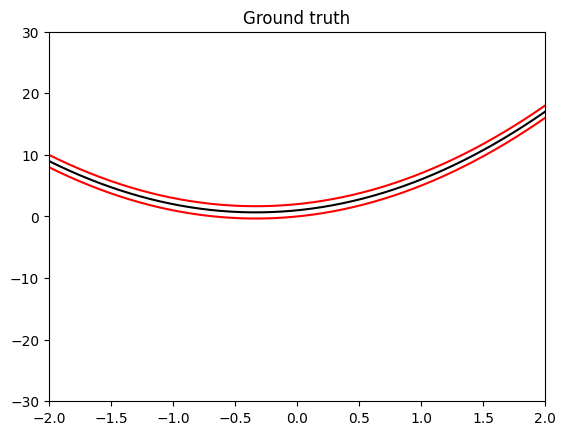

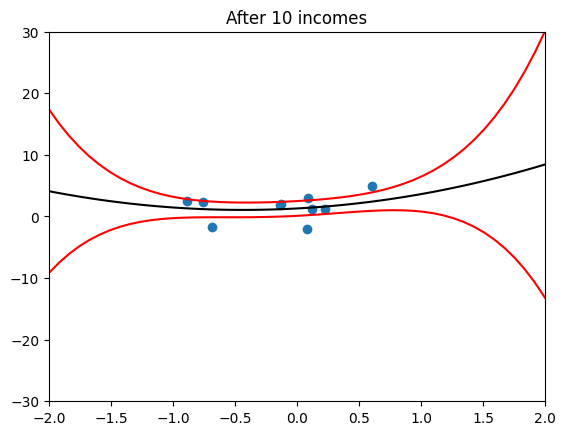

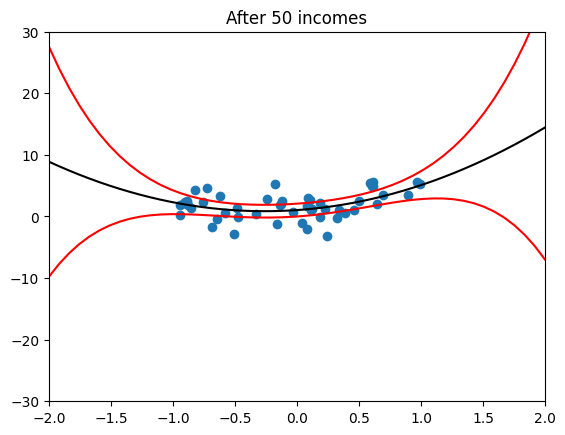

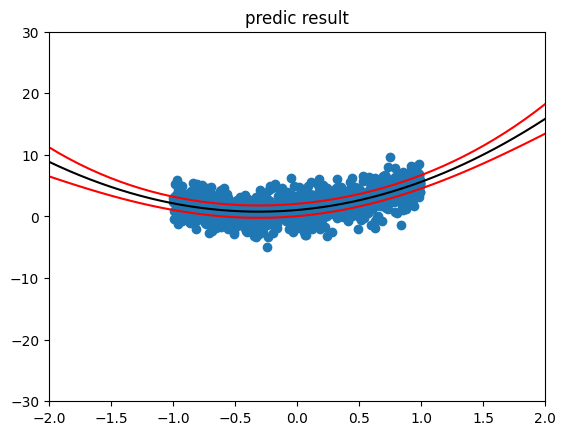

In [11]:
plot(S , M ,x , y , [1,2,3])